# ST445 Managing and Visualizing Data

## Week 8 Assignment
---

#### Your Candidate Number: 30499

In [17]:
#Import all the packages that are needed for the project
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
%matplotlib inline

from sklearn.datasets import make_biclusters 
#from sklearn.datasets import samples_generator as sg 
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score


from sklearn.metrics.pairwise import cosine_similarity 
import seaborn as sns  

<br>

Disable the auto-scrolling in the cells of this notebook so that the plots can be easily read:

In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

### Q1. Matrix data visualization (5 points)

In this exercise you need to visualize co-usage of pairs of programming languages in GitHub repositories. You have two datasets for this analysis (a) ```repos-per-lang.csv``` that contains information about how many GitHub repositories use specific programming language and (b) ```lang-pairs-per-repo-top-1000.csv``` that contains information about how many times two programming languages are used in a common repository. In particular, you need to:

Plot a heatmap visualizing the cosine similarity of pairs of programming languages with respect to their co-usage in GitHub repositories with the rows and the columns ordered according to: (a) random permutation and (b) a monotonic order of the Fiedler vector elements. 

In [33]:
#Import the csv files into panda Dataframes:
languages = pd.read_csv('ReposPerLang.csv')
pairs = pd.read_csv('LangPairsPerRepoTop1000.csv')

#Rename the columns of the 2 dataframes, so that they are easier and more meaningful to use later on:
languages.columns = ['single_usage_cnt', 'lang']
pairs.columns = ['lang1', 'lang2', 'co_usage_cnt']



#Merge the 2 dataframes so that the 'pairs' dataframe gets an additional column from the 'languages' dataframe 
#indicating how many GitHub repositories use the first programming language (lang1) from the pair. 
#The additional column is named 'single_usage_cnt1':
merged_lang1 = pd.merge(left=pairs, right=languages, how='left', left_on='lang1', right_on='lang')
merged_lang1 = merged_lang1.drop(columns = ['lang']) #Drop the 'lang' column coming from the 'languages' dataframe, 
                                                     #as it has thesame values with the 'lang1' column
merged_lang1.rename(columns=({ 'single_usage_cnt': 'single_usage_cnt1'}), #Rename the column so that we can understand 
                    inplace=True)                                         #that it shows the usage from the first language



#Similar as before, merge the 2 dataframes so that the 'merged_lang1' dataframe gets an additional column from the 'languages' dataframe 
#indicating how many GitHub repositories use the second programming language (lang2) from the pair. 
#The additional column is named 'single_usage_cnt2':
merged_lang2 = pd.merge(left=merged_lang1, right=languages, how='left', left_on='lang2', right_on='lang')
merged_lang2.rename(columns=({ 'single_usage_cnt': 'single_usage_cnt2'}), inplace=True)
merged_lang2 = merged_lang2.drop(columns = ['lang'])
merged_lang2

,lang1,lang2,co_usage_cnt,single_usage_cnt1,single_usage_cnt2
0,JavaScript,CSS,716441,1160725,871264
1,JavaScript,HTML,602955,1160725,814370
2,HTML,CSS,589971,814370,871264
3,Shell,JavaScript,221484,671755,1160725
4,Shell,Python,217501,671755,567150
...,...,...,...,...,...
995,Gnuplot,C,2199,3357,315057
996,Ruby,AppleScript,2192,399850,4478
997,XS,C,2192,2297,315057
998,SQLPL,Batchfile,2189,5898,103957


<br>

**Normalize the co_usage:**
<br>
Using the single usage of language 1 and language 2 (*single_usage_cnt1*, *single_usage_cnt2*) we normalize the *co_usage_cnt*, so that the new column *co_usage_norm* can show the percentage of two languages being co-used out of the average number of repositories that they have been individually used.
So, the *co_usage_norm* column will get values from 0 to 1, where 0 will be the value when the two languages were not used in any repository together and 1 when the two languages were always used together.

In [35]:
merged_lang2['co_usage_norm'] = merged_lang2['co_usage_cnt']/(merged_lang2[['single_usage_cnt1', 'single_usage_cnt2']].mean(axis=1))

merged_lang2
merged_lang2[merged_lang2['lang1'] == 'Assembly']

,lang1,lang2,co_usage_cnt,single_usage_cnt1,single_usage_cnt2,co_usage_norm
192,Assembly,ASP,13367,53347,37556,0.294094


<br>

**Transform to pivot table and impute NaNs**
<br>
- Create a pivot table, named  *lang_pivot*, based on the *merged_lang2* dataframe, so that lang1 and lang2 are the rows and columns equivallently and the values are the co_usage_norm.
- Replace all the NaN values with zeros, since NaNs in this case mean that the co-usage between the 2 languages is zero, hence the normalized co-usage will also be zero.

In [21]:
#Create the pivot table:
lang_pivot = merged_lang2.pivot_table(values='co_usage_norm', index=['lang1'], columns=['lang2'])

#Replace the NaN values with zero:
lang_pivot = lang_pivot.fillna(0)

<br>

**Make the table symmetric**
<br>
Make the *lang_pivot* table symmetric, so that we can easily keep track of the column and row names to use them in the heatmap below:

In [22]:
#Create a list with all the column names:
column_list = lang_pivot.columns.values.tolist() 

#Create a list with all the row names:
row_list = list(lang_pivot.index)

#Get elements that are in column_list but not in row_list:
not_in_rows = list(set(column_list) - set(row_list))

#Get elements that are in row_list but not in column_list:
not_in_columns = list(set(row_list) - set(column_list))

    
#Add one extra row for each language that exists as a column, but not as a row:
for nr in not_in_rows:                             #loop through the list of rows that need to be added
    columns_cnt = lang_pivot.shape[1]              #get the number of columns so that we can correctly create the extra row to be added
    new_row =[0] * columns_cnt                     #Create a list with number of elements as many as the number of columns and fil them with zeros
    row_df = pd.DataFrame([new_row], index = [nr]) #Make the list a dataframe 
    row_df.columns = column_list                   #Name the 1-row dataframe columns the same with the main table columns
    lang_pivot = pd.concat([row_df, lang_pivot])   #Concatinate the main dtaframe with the new 1-row dataframe


#Add one extra column for each language that exists as a row, but not as a column:
for nc in not_in_columns: #loop through the list of columns that need to be added
    lang_pivot[nc] =0     #Set the value of the new column to zero, since it has no co-usage with any language

    
#Get the updated column and row list:    
column_list = lang_pivot.columns.values.tolist() 
row_list = list(lang_pivot.index)

#Sort the column and row lists and get a list of their sorted indexes
column_sort_index = np.argsort(column_list)
row_sort_index = np.argsort(row_list)

#Transform the *lang_pivot* dataframe so that the rows and columns are sorted in asceding order, using the indexes created above.
#The final table *lang_pivot_symm* has its column names in the same sequence as its row names
lang_pivot_symm = lang_pivot.iloc[row_sort_index, column_sort_index]  

<br>

**Set the diagonal = 1**
<br>
Set the diagonal values to be equal to 1, since a language will be always co-used with itself.

In [23]:
for name in lang_pivot_symm.columns:
    for row in lang_pivot_symm.index:
        if name == row:
            lang_pivot_symm.loc[name,row] = 0

<br>

**Calculate the cosine similarity**
<br>
Calculate the cosine similarity of pairs of programming languages with respect to their normalized co-usage in GitHub repositories 

In [24]:
similarity_matrix = cosine_similarity(lang_pivot_symm)

<br>


## Random Permutation

<br>
- Randomly permute the rows and columns of the similarity matrix.
<br>
- Prepare the dataframe to use for the heatmap so that it has row and column names in the correct order and hence correctly display them on the heat-map

In [25]:
#Get the updated column list and row list, so that they can be used in the heat-map.
#In this case rows and column names are in the same order
col_row_list_sorted = np.array(column_list)[column_sort_index]

#Calculate the number of rows or columns in the similarity matrix, in order to use it in the next step
number_of_rows_or_columns = len(col_row_list_sorted)

#Randomly permute the similarity matrix and create the new 'similarity_matrix_rand' matrix
#By using the same permutation index for both rows and columns I maintain the symmetry of the matrix
random_idx = np.random.permutation(number_of_rows_or_columns) #generate random permutation indexes
similarity_matrix_rand = similarity_matrix[random_idx,:] # permute rows
similarity_matrix_rand = similarity_matrix_rand[:,random_idx] # permute columns

#Get the list of columns and rows based on the order of the columns and rows on the similarity_matrix_rand, 
#in other words, based on the order that random permutation indicated. This will be used for the heat map
col_row_rand_sorted = col_row_list_sorted[random_idx]

#Transform the similarity_matrix_rand to a dataframe and add column and row names, 
#so that they can be used in the heat-map below
similarity_rand_df =pd.DataFrame(similarity_matrix_rand, index = col_row_rand_sorted , columns = col_row_rand_sorted)

<br>
- Plot the heat map for random permutation

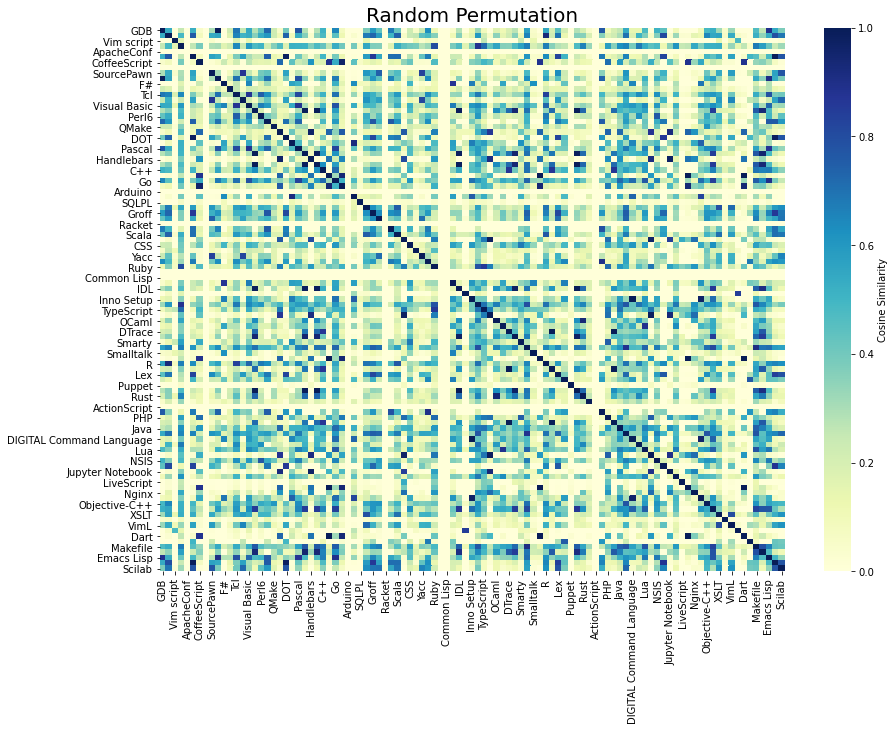

In [26]:
#Plot the heatmap:
plt.figure(figsize = (14,10))  #Set the size of the graph

#create the heatmap based on the similarity_df dataframe, with the specified colour pallete 
#and the specified title for the colour bar:
p1 = sns.heatmap(similarity_rand_df, cmap="YlGnBu", cbar_kws={'label': 'Cosine Similarity'}) 

plt.title( "Random Permutation", fontsize=20 ) #Set the title of the heatmap and fortsize of it

plt.show()                                     #Display the heatmap without the text

## Monotonic order of the Fiedler vector elements

Reordering rows and columns in order of the Fiedler vector elements

In [27]:
# compute the Laplacian matrix, using the randomly permuted similarity matrix from the previous step 
L = np.diag(np.sum(similarity_matrix_rand,1)) - similarity_matrix_rand

# check that L is a symmetrix matrix
print((L.transpose() == L).all())

# compute eigenvalues and eigenvectors of the Laplacian matrix
eig_values, eig_vectors = np.linalg.eigh(L)

#sort the indexes of the eigenvalues in ascending order
arg_eig_values = np.argsort(eig_values)

#use the sorted indexes to sort the eigenvalues and the eigenvectors
eig_values=eig_values[arg_eig_values]
eig_vectors=eig_vectors[:,arg_eig_values]

# get the Fiedler eigenvector
fiedler = eig_vectors[:,1]

# permutation in the order of Fiedler vector elements
col_row_fdlr_idx = np.argsort(fiedler)

# permute rows
similarity_matrix_fdlr = similarity_matrix_rand[col_row_fdlr_idx,:]
# permute columns
similarity_matrix_fdlr= similarity_matrix_fdlr[:,col_row_fdlr_idx]


True


<br>
- Prepare the dataframe to use for the heatmap so that it has row and column names in the correct order and hence correctly display them on the heat-map

In [28]:
#Get the list of columns and rows based on the order of the columns and rows on the similarity_matrix_fdlr, 
#so based on the order that came out ofter randomly permuting them 
col_row_fdlr_sorted = col_row_list_sorted[col_row_fdlr_idx]


#Transform the similarity_matrix to a dataframe and add column and row names, so that they can be used in the heat-map below
similarity_fdlr_df =pd.DataFrame(similarity_matrix_fdlr, index = col_row_fdlr_sorted , columns = col_row_fdlr_sorted)

<br>
- Plot the heat-map of the similarity matrix order by the Fiedler vector elements

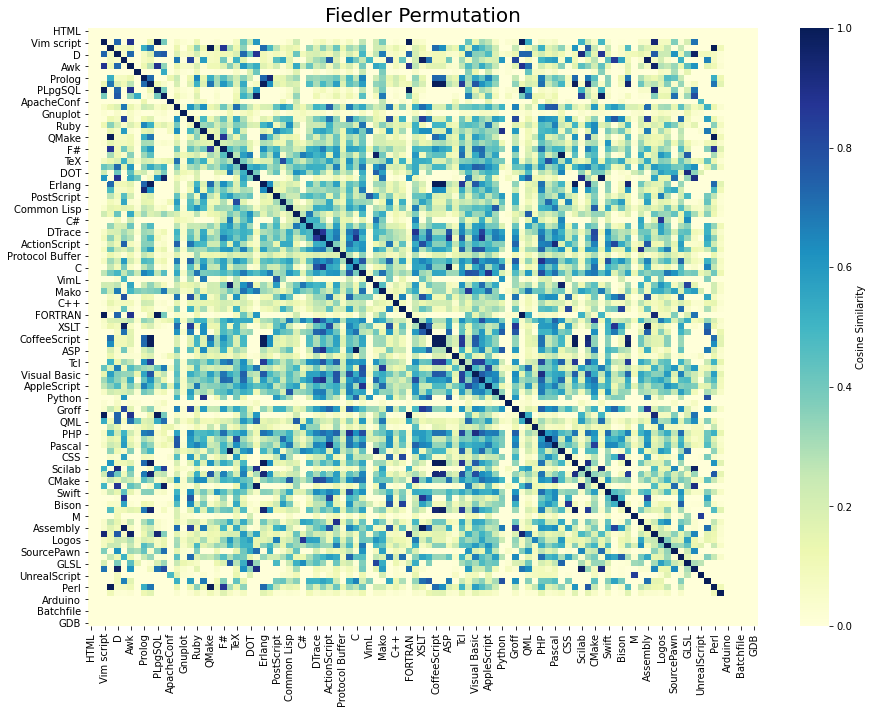

In [29]:
plt.figure(figsize = (15,11))  #Set the size of the graph

#create the heatmap based on the similarity_df dataframe, with the specified colour pallete 
#and the specified title for the colour bar:
p1 = sns.heatmap(similarity_fdlr_df, cmap="YlGnBu", cbar_kws={'label': 'Cosine Similarity'}) 

plt.title( "Fiedler Permutation", fontsize=20 ) #Set the title of the heatmap and fortsize of it


plt.show()                                     #Display the heatmap without the text

### Q2. Spectral co-clustering (5 points)

In this exercise you need to evaluate the robustness of the spectral co-clustering algorithm to random perturbation of a matrix with a bi-cluster structure. In particular, you need to:


* Generate matrices each with 300 rows and 300 columns and four bi-clusters, using the ```make_biclusters()``` function, for 20 evenly spaced values of the standard deviation of noise in the interval [0,100] 
* Randomly permute rows and columns of these matrices 
* Apply the spectral co-clustering algorithm to each of these randomly permuted matrices and compute the corresponding consensus score 
* Plot the consensus score versus the standard deviation of noise (similar to the one on slide 48 of the lecture)

Hint: For the `xlabel`, consider using the latex symbol $\sigma$

<br>

Create a function that expects as input the value of sigma (standard deviation of noise), generates a matrix with given number of rows, columns and bi-clusters, randomly permutes the rows and columns of the matrix, applies the spectral co-clustering algorithm to the matrix and computes the corresponding consensus score.

In [30]:
def matrix_to_score(sigma):
    
    data_original, rows, columns = make_biclusters(shape=(nrows, nrows), n_clusters=nblocks, noise=sigma,
                                          shuffle=False, random_state=0) 
    
    #Randomly permute rows and columns of these matrices
    rng = np.random.RandomState(0) #set a specific seed (0) so that it is the same across all tables and we can focus only on the difference based on the different sigma
    row_idx = rng.permutation(data_original.shape[0])
    col_idx = rng.permutation(data_original.shape[1])
    data_random_permutation = data_original[row_idx][:, col_idx]


    #Apply the spectral co-clustering algorithm to each of these randomly permuted matrices 
    #and compute the corresponding consensus score
    model = SpectralCoclustering(n_clusters=nblocks, random_state=0)
    model.fit(data_random_permutation)

    fit_data = data_random_permutation[np.argsort(model.row_labels_)]
    fit_data = fit_data[:, np.argsort(model.column_labels_)]

    #Estimate the goodness of fit of the biclusters:
    #It can be calculated only when we know the original data matrix
    score = consensus_score(model.biclusters_,(rows[:, row_idx], columns[:, col_idx]))
    
    return score

<br>
Run the function for 20 different sigmas and store the consensus score in a list and the values of the different sigma in another list

In [31]:
# Run for all 20 different sigmas
nblocks = 4 #create the variable to be used as the number of bi-clusters to be created in each iteration
nrows = 300 #create the variable to be used as the number of rows and columns of the matrices to be created

score_list = [] #initialize the score list:

sigma_list = np.linspace(0,100, 20) #create a list with 20 elements in the interval [0,100] equally spaced

#Run the function for all the sigmas in the list
for s in sigma_list:
    score = matrix_to_score(s)
    score_list.append(score)


<br>
Plot the consensus score versus for all the 20 matrices generated above (score_list) against the standard deviation of noise for each matrix (sigma_list)

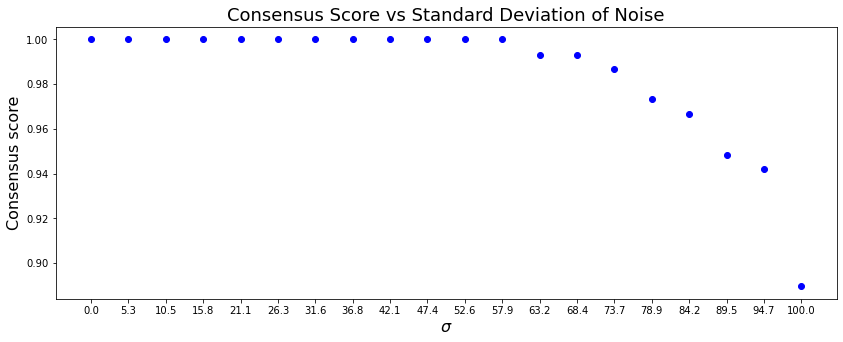

In [32]:
fig, ax = plt.subplots(figsize=(14, 5)) #set the size of the plot
plt.plot(sigma_list, score_list, 'bo') #set the data on the x and y axis and the type of the points to be blue dots

ax.set_xlabel(r'$\sigma$', fontsize=16) #set the label on the x axis using latex
ax.set_ylabel('Consensus score', fontsize=16) #set the label on the y axis

plt.xticks(sigma_list) #since the sigmas used are equally distanced I set them to be the ticks on the x axis

plt.title('Consensus Score vs Standard Deviation of Noise', fontsize=18) #define the title of the plot
plt.show() #display the plot only